In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from tqdm import tqdm
import pywt
from datetime import datetime

In [3]:
#우선 교차검증 시 데이터 분할이 어떻게 이루어지는지 그려 볼 수 있게 해주는 helper function을 가져오자.
from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [4]:
train_data = pd.read_csv("data/train_data.csv")
#new_data = pd.read_csv("data/newdata.csv")




In [5]:
#new_data=new_data[(new_data['Day']==201) | (new_data['Day']==202)]

In [6]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [7]:
#new_data = new_data.fillna(method="ffill").fillna(method='bfill')
#new_data.isnull().sum()

# 기타 전처리

In [8]:
df_updated = train_data.copy()


In [9]:
df = df_updated[['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].copy()
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [10]:
df['Tmstamp'][0].split(':')

['00', '00']

In [11]:
a, b = df['Tmstamp'][20].split(':')
a, b

('03', '20')

In [12]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

df['hour'] = df['Tmstamp'].apply(lambda x: make_hour(x))   

In [13]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

df['minute'] = df['Tmstamp'].apply(lambda x: make_minute(x))

In [14]:
# 순서 넘겨주기.
df = df[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [15]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
#train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64


In [16]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [17]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [18]:
df = train_data.copy()

In [19]:
df = df.sort_values(by=['hour', 'Day', 'TurbID', 'minute'])
df.reset_index(drop=True, inplace=True)
df

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [20]:
df = df.interpolate()
df = df.fillna(method='bfill')

In [21]:
df.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

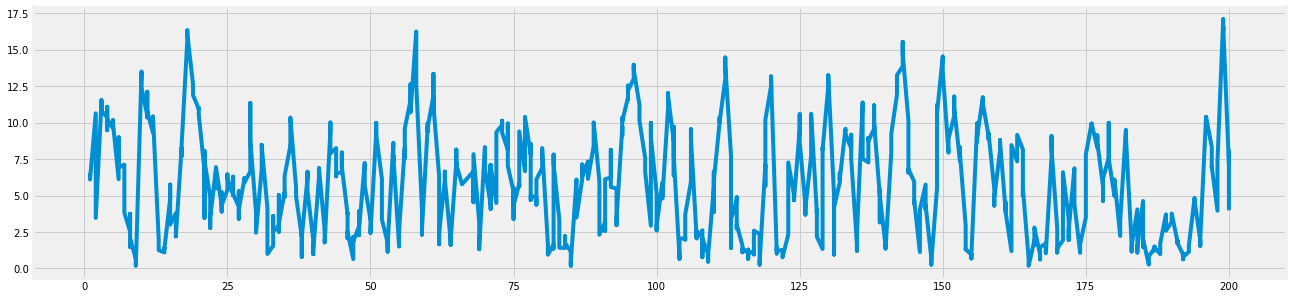

In [22]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 0 # hour
for i in range(1, 2): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['hour']==j)]['Day'], df[(df['TurbID']==i) & (df['hour']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [23]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [24]:
train_data = train_data.sort_values(by=['TurbID', 'Day', 'hour', 'minute'])
train_data.reset_index(drop=True, inplace=True)
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [25]:
del df

----

In [26]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [27]:
# 1차분 변수 추가.
#train_data['Wspd_1']=0

#for turb in tqdm(range(1,135)):
#    train_data.loc[train_data['TurbID']==turb,'Wspd_1']=train_data.loc[train_data['TurbID']==turb,'Wspd']-train_data.loc[train_data['TurbID']==turb,'Wspd'].shift().fillna(method='bfill')




In [28]:
train_data['minute'][:7]

0    0
1    1
2    2
3    3
4    4
5    5
6    0
Name: minute, dtype: int64

In [29]:
train_data.describe()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
count,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06
mean,6.750000e+01,1.005000e+02,7.150000e+01,1.150000e+01,2.500000e+00,5.232055e+00,2.614239e-01,4.572761e+01,3.132578e+01,1.841302e+02,2.581436e+01,2.579058e+01,2.577532e+01,-1.489652e+01,3.586304e+02
std,3.868140e+01,5.773431e+01,4.156822e+01,6.922187e+00,1.707825e+00,3.446809e+00,2.987438e+01,8.394415e+01,1.716360e+01,1.671287e+02,3.813392e+01,3.812350e+01,3.811421e+01,7.072748e+01,4.249115e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.030460e+03,-2.730300e+02,-2.731700e+02,-8.848600e+02,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,0.000000e+00
25%,3.400000e+01,5.075000e+01,3.575000e+01,5.750000e+00,1.000000e+00,2.440000e+00,-3.810000e+00,2.069000e+01,2.611000e+01,5.112000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-4.070000e+01,0.000000e+00
50%,6.750000e+01,1.005000e+02,7.150000e+01,1.150000e+01,2.500000e+00,4.570000e+00,-2.400000e-01,2.829000e+01,3.279000e+01,1.909200e+02,6.500000e-01,6.500000e-01,6.495154e-01,-3.200000e-01,1.921600e+02
75%,1.010000e+02,1.502500e+02,1.072500e+02,1.725000e+01,4.000000e+00,7.270000e+00,3.350000e+00,3.389000e+01,3.819000e+01,3.211744e+02,7.687000e+01,7.650000e+01,7.629000e+01,-2.200000e-01,5.627400e+02
max,1.340000e+02,2.000000e+02,1.430000e+02,2.300000e+01,5.000000e+00,2.629000e+01,2.266950e+03,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.852000e+02,1.567020e+03


In [30]:
# 순서 넘겨주기.
train_data = train_data[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute',  
         'Wdir', 'Etmp', 'Itmp', 'Ndir',
         'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv','Wspd']]

In [31]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd
0,1,1,0,0,0,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
1,1,1,1,0,1,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
2,1,1,2,0,2,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,6.27
3,1,1,3,0,3,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,6.42
4,1,1,4,0,4,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,6.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,4.86
3859196,134,200,140,23,2,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,4.46
3859197,134,200,141,23,3,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,4.23
3859198,134,200,142,23,4,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,4.36


# 테스트셋 제작

In [32]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.drop(['index'],axis=1,inplace=True)
sample_submission

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,201,00:00,0,0,0,0,0,0,0,0,0,9999
1,1,201,00:10,0,0,0,0,0,0,0,0,0,9999
2,1,201,00:20,0,0,0,0,0,0,0,0,0,9999
3,1,201,00:30,0,0,0,0,0,0,0,0,0,9999
4,1,201,00:40,0,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,202,23:10,0,0,0,0,0,0,0,0,0,9999
38588,134,202,23:20,0,0,0,0,0,0,0,0,0,9999
38589,134,202,23:30,0,0,0,0,0,0,0,0,0,9999
38590,134,202,23:40,0,0,0,0,0,0,0,0,0,9999


In [33]:
tms_list = list(pd.unique(sample_submission["Tmstamp"]))
hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]

sample_submission["hour"] = sample_submission["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )

In [34]:
tms_list = list(pd.unique(sample_submission["Tmstamp"]))
minute_list = [ int(datetime.strptime(t,"%H:%M").minute/10) for t in tms_list]

sample_submission["minute"] = sample_submission["Tmstamp"].apply(lambda x : minute_list[tms_list.index(x)] )

In [35]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(sample_submission["Tmstamp"]))

sample_submission["Tmstamp"] = sample_submission["Tmstamp"].apply(lambda x : tms_list.index(x))

In [36]:
sample_submission

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,hour,minute
0,1,201,0,0,0,0,0,0,0,0,0,0,9999,0,0
1,1,201,1,0,0,0,0,0,0,0,0,0,9999,0,1
2,1,201,2,0,0,0,0,0,0,0,0,0,9999,0,2
3,1,201,3,0,0,0,0,0,0,0,0,0,9999,0,3
4,1,201,4,0,0,0,0,0,0,0,0,0,9999,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,202,139,0,0,0,0,0,0,0,0,0,9999,23,1
38588,134,202,140,0,0,0,0,0,0,0,0,0,9999,23,2
38589,134,202,141,0,0,0,0,0,0,0,0,0,9999,23,3
38590,134,202,142,0,0,0,0,0,0,0,0,0,9999,23,4


In [37]:
# 순서 넘겨주기.
sample_submission = sample_submission[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute',  
         'Wdir', 'Etmp', 'Itmp', 'Ndir',
         'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv','Wspd']]

In [38]:
sample_submission

,TurbID,Day,Tmstamp,hour,minute,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd
0,1,201,0,0,0,0,0,0,0,0,0,0,0,9999,0
1,1,201,1,0,1,0,0,0,0,0,0,0,0,9999,0
2,1,201,2,0,2,0,0,0,0,0,0,0,0,9999,0
3,1,201,3,0,3,0,0,0,0,0,0,0,0,9999,0
4,1,201,4,0,4,0,0,0,0,0,0,0,0,9999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,202,139,23,1,0,0,0,0,0,0,0,0,9999,0
38588,134,202,140,23,2,0,0,0,0,0,0,0,0,9999,0
38589,134,202,141,23,3,0,0,0,0,0,0,0,0,9999,0
38590,134,202,142,23,4,0,0,0,0,0,0,0,0,9999,0


# 데이터 구성

In [39]:
train_data=train_data.drop(['Wdir', 'Etmp', 'Itmp','Ndir', 'Pab1', 'Pab2', 
                        'Pab3', 'Prtv', 'Patv'],
                       axis=1)
sample_submission=sample_submission.drop(['Wdir', 'Etmp', 'Itmp','Ndir', 'Pab1', 'Pab2', 
                        'Pab3', 'Prtv', 'Patv'],
                       axis=1)

In [40]:

def get_newdata_sample(turbin_sample):
    shifted_list = []
    for i in range(288, 577): # 앞의 Tmstamp 20을 가져옴.
        shifted=turbin_sample['Wspd'].shift(i)
        shifted.name=f'Wspd_lags{i}'
        shifted_list.append(shifted)
        #turbin_sample[f'Wspd_lags{i}'] = turbin_sample['Wspd'].shift(i)
    shifted_list=pd.concat(shifted_list,axis=1)
    turbin_sample=pd.concat([turbin_sample,shifted_list],axis=1)
    turbin_sample.dropna(inplace=True)
    del shifted_list
    return turbin_sample

In [41]:
all_turbins = []
for turbid in tqdm(range(1,135)):
    train_data_sample = train_data[train_data['TurbID']==turbid].copy()
    sample_submission_sample = sample_submission[sample_submission['TurbID']==turbid].copy()
    train_data_sample=pd.concat([
        train_data_sample,
        sample_submission_sample],axis=0,ignore_index=True)
    returned_data=get_newdata_sample(train_data_sample.copy())
    all_turbins.append(returned_data)
    
    
    del returned_data
    del train_data_sample
    del sample_submission_sample
    
turbin_lag=pd.concat(all_turbins,axis=0,ignore_index=True)


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:16<00:00,  8.01it/s]


In [42]:
turbin_lag

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wspd_lags288,Wspd_lags289,Wspd_lags290,Wspd_lags291,...,Wspd_lags567,Wspd_lags568,Wspd_lags569,Wspd_lags570,Wspd_lags571,Wspd_lags572,Wspd_lags573,Wspd_lags574,Wspd_lags575,Wspd_lags576
0,1,5,0,0,0,9.63,11.45,11.76,11.80,11.98,...,6.25,6.44,6.70,6.77,6.10,6.25,6.42,6.27,6.17,6.17
1,1,5,1,0,1,9.72,10.93,11.45,11.76,11.80,...,6.87,6.25,6.44,6.70,6.77,6.10,6.25,6.42,6.27,6.17
2,1,5,2,0,2,10.17,10.69,10.93,11.45,11.76,...,6.60,6.87,6.25,6.44,6.70,6.77,6.10,6.25,6.42,6.27
3,1,5,3,0,3,10.17,11.54,10.69,10.93,11.45,...,6.71,6.60,6.87,6.25,6.44,6.70,6.77,6.10,6.25,6.42
4,1,5,4,0,4,10.06,10.63,11.54,10.69,10.93,...,6.86,6.71,6.60,6.87,6.25,6.44,6.70,6.77,6.10,6.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820603,134,202,139,23,1,0.00,4.86,5.13,4.28,4.52,...,15.15,15.02,14.24,15.07,15.91,16.24,16.24,15.71,15.08,14.55
3820604,134,202,140,23,2,0.00,4.46,4.86,5.13,4.28,...,16.03,15.15,15.02,14.24,15.07,15.91,16.24,16.24,15.71,15.08
3820605,134,202,141,23,3,0.00,4.23,4.46,4.86,5.13,...,15.96,16.03,15.15,15.02,14.24,15.07,15.91,16.24,16.24,15.71
3820606,134,202,142,23,4,0.00,4.36,4.23,4.46,4.86,...,15.99,15.96,16.03,15.15,15.02,14.24,15.07,15.91,16.24,16.24


In [43]:

turbin_lag_train=turbin_lag[(turbin_lag['Day']!=201) & (turbin_lag['Day']!=202)].copy()


turbin_lag_test=turbin_lag[(turbin_lag['Day']==201) | (turbin_lag['Day']==202)].copy()


In [44]:
del turbin_lag
del all_turbins
del train_data

turbin_lag_train_y=turbin_lag_train['Wspd'] 
turbin_lag_train.drop(['Wspd'],axis=1,inplace=True)

turbin_lag_test.drop(['Wspd'],axis=1,inplace=True)

In [45]:
import gc

gc.collect()

0

# 모델 학습

In [48]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':1000,}
lgbm_reg = LGBMRegressor(n_estimators=1000,device = "gpu")
lgbm_reg.fit(turbin_lag_train, turbin_lag_train_y)

LGBMRegressor(device='gpu', n_estimators=1000)

In [ ]:
pred=lgbm_reg.predict(turbin_lag_test)

In [ ]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.drop(['index'],axis=1,inplace=True)
sample_submission

In [ ]:
sample_submission['Wspd']=pred

In [ ]:
sample_submission.to_csv("./lgbm_wspd.csv",index=False)

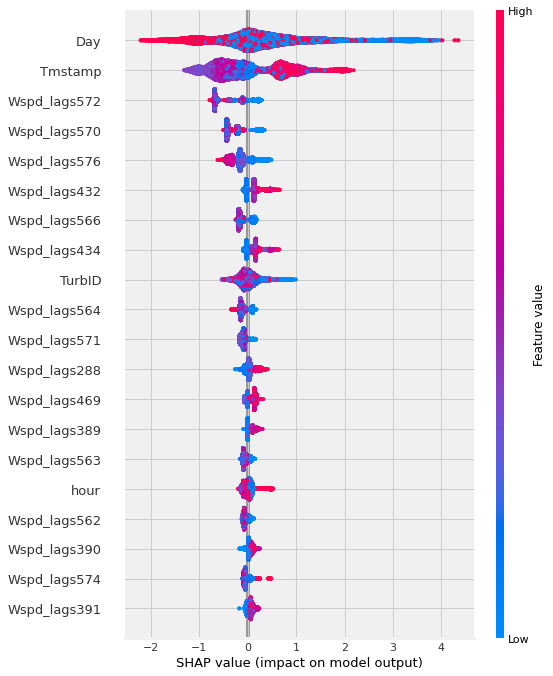

In [49]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(lgbm_reg)
shap_values = explainer.shap_values(turbin_lag_test)
fig = shap.summary_plot(shap_values, turbin_lag_test)
#plt.savefig(f'{PATH}/shap.png', dpi=300, bbox_inches="tight")